## Model selection

#### The hyper parameter for each model is optimized using bayesian optimization and 5 fold stratified Cross Validation. Each model is trained on there different transformations of the original dataset. Since the data set is imbalanced be use balanced accuracy as the metric.

In [3]:
# imports
import lightgbm as lgb #light gradient boosted tree
from sklearn.model_selection import train_test_split, StratifiedKFold # train and test split
from sklearn.metrics import balanced_accuracy_score,precision_score# metrics
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import numpy as np
import pandas as pd # reading data
import warnings
warnings.simplefilter("ignore")

In [4]:
# reading the data
df_encoded = pd.read_csv('online_shoppers_intention_encoded.csv', index_col=False)
df_scaled = pd.read_csv('online_shoppers_intention_encoded_scaled.csv', index_col=False)
df_transformed = pd.read_csv('online_shoppers_intention_encoded_scaled_transformed.csv', index_col=False)

In [5]:
#seperate label
label = df_encoded.pop('Revenue').astype('int')
_,_ = df_scaled.pop('Revenue'),df_transformed.pop('Revenue')

In [7]:
#split object for CV 
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
#Hyperparameter search space for gradient boosed trees
lgb_space = {'lr':hp.loguniform('lr',-6.9,-2.3),'num_leaves':hp.quniform('num_leaves',15,255,1),
         'max_depth':hp.choice('max_depth',[-1,9,12]),'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0)}

In [8]:
def lgb_optimizer(params):
    '''A function to optimize  lgb classifier
    :params:=params , dictionary containing the Hyper-parameters for the classifier
    returns true loss and validation loss
    '''
    if 'num_leaves' in params:
        params['num_leaves']=int(params['num_leaves'])
    if 'max_depth' in params:
        params['max_depth']=int(params['max_depth'])
    val_score=[]
    true_scores=[]
    rd=1
    for train_index, test_index in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
        clf = lgb.LGBMClassifier(n_estimators=2000,**params)
        clf.fit(X_tr,y_tr,eval_set=(X_val,y_val),early_stopping_rounds =200,eval_metric='logloss',verbose=False)
        y_pred = clf.predict(X_val)
        y_tr_pred=clf.predict(X_tr)
        score=balanced_accuracy_score(y_val,y_pred,)
        true_score=balanced_accuracy_score(y_tr,y_tr_pred)
        val_score.append(score)
        true_scores.append(true_score)
        rd+=1
    mean,std =np.mean(val_score),np.std(val_score)
    true_mean=np.mean(true_scores)
    print("mean: {}, Std: {}".format(mean,std))
    return {'loss':-mean,'status': STATUS_OK,'true_loss':-true_mean}

In [9]:
#split into train and test and call the fmin(optimizer) function for encoded dataset
X_train,X_test,y_train,y_test = train_test_split(df_encoded,label,test_size=0.2,random_state=42)
trials_encoded = Trials()
best_e= fmin(lgb_optimizer,lgb_space, algo=tpe.suggest, max_evals=20, trials=trials_encoded)

mean: 0.7617145711775637, Std: 0.011096103324751685                                                                    
mean: 0.7823353511546445, Std: 0.01605713721017053                                                                     
mean: 0.7528195095494519, Std: 0.025083682968686218                                                                    
mean: 0.7774682674271404, Std: 0.012387011946309076                                                                    
mean: 0.7506421682997939, Std: 0.014579309421961291                                                                    
mean: 0.78187725489657, Std: 0.011160865152920621                                                                      
mean: 0.7741578761889171, Std: 0.009488687260092898                                                                    
mean: 0.7636328281698519, Std: 0.014629157731417484                                                                    
mean: 0.7708845380484701, Std: 0.0193256

In [10]:

#for scaled dataset
X_train,X_test,y_train,y_test = train_test_split(df_scaled,label,test_size=0.2,random_state=42)
trials_scaled = Trials()
best_scaled = fmin(lgb_optimizer, lgb_space, algo=tpe.suggest, max_evals=20, trials=trials_scaled)

mean: 0.7613342051954316, Std: 0.014068365983731792                                                                    
mean: 0.7699905211552569, Std: 0.02141441009582809                                                                     
mean: 0.7498763813682278, Std: 0.016509879357649613                                                                    
mean: 0.7778987644385236, Std: 0.014297575850252089                                                                    
mean: 0.7651975311264765, Std: 0.005114829904231287                                                                    
mean: 0.7644419978430474, Std: 0.011590741396906787                                                                    
mean: 0.7762850864093237, Std: 0.013418337595139263                                                                    
mean: 0.7820605646317247, Std: 0.019749303100836633                                                                    
mean: 0.7684662079497329, Std: 0.0102326

In [11]:

#for transformed dataset
X_train,X_test,y_train,y_test = train_test_split(df_transformed,label,test_size=0.2,random_state=42)
trials_transformed = Trials()
best_transformed = fmin(lgb_optimizer, lgb_space, algo=tpe.suggest, max_evals=20, trials=trials_transformed)

mean: 0.7441790395687095, Std: 0.014219068306850545                                                                    
mean: 0.7551621588521912, Std: 0.0230829318761551                                                                      
mean: 0.7658622562024886, Std: 0.007210758400881086                                                                    
mean: 0.7768100282053428, Std: 0.005204424267552645                                                                    
mean: 0.7786523669618834, Std: 0.008222377033777829                                                                    
mean: 0.7684575289020411, Std: 0.005128302535505574                                                                    
mean: 0.772055272224673, Std: 0.011409949185906248                                                                     
mean: 0.7661092997651846, Std: 0.009561951057972912                                                                    
mean: 0.7763480329366423, Std: 0.0161635

In [12]:
def model_trainer(Data,label,params,classifier='lgb',test_size=0.2):
    '''A function to train a model. 
    parameters:
    Data :=pandas dataset or numpy array of features
    label:=pandas dataset or numpy array of labels for features 
    params:=python dict parametes for the model
    model:=keras model object or sklearn classifier object
    test_size:=Float (0,1) fraction for test split
    return
    model:=str 'keras','lgb'
    train_score:=float balanced accuracy train score
    test_score:=float balanced accuracy test score
    returns-trained model,train_score,test_score
    '''
    X_train,X_test,y_train,y_test = train_test_split(Data,label,test_size=test_size,random_state=42)
    if classifier=='lgb':
        if 'num_leaves' in params:
            params['num_leaves']=int(params['num_leaves'])
        if 'max_depth' in params:
            #max_depth=[-1,9,12]#max_depth choice list
            params['max_depth']=-1#int(params['max_depth'])#best returns an index corresponding the choice
        clf = lgb.LGBMClassifier(n_estimators=5000,**params)
        clf.fit(X_train,y_train,eval_set=(X_test,y_test),early_stopping_rounds =200,eval_metric='auc',verbose=False)
        train_pred=clf.predict(X_train)
        test_pred=clf.predict(X_test)
    elif classifier=='keras':
        opt=['adam','sgd']
        if 'optimizer' in params:
            params['optimizer'] =opt[params['optimizer']]
        clf = model(feature_size=X_train.shape[-1],**params)
        clf.fit(X_train,y_train,epochs=20,batch_size=128,verbose=0)
        train_pred=np.round(clf.predict(X_train))
        test_pred=np.round(clf.predict(X_test))
    train_score = balanced_accuracy_score(train_pred,y_train)
    test_score= balanced_accuracy_score(test_pred,y_test)
    return clf,train_score,test_score

In [13]:
print(best_e)
print(best_scaled)
print(best_transformed)

{'colsample_bytree': 0.8885645944897853, 'lr': 0.06577823295361401, 'max_depth': 0, 'num_leaves': 27.0}
{'colsample_bytree': 0.7417506062288691, 'lr': 0.014273085467069426, 'max_depth': 0, 'num_leaves': 19.0}
{'colsample_bytree': 0.747983242114469, 'lr': 0.01015619803851726, 'max_depth': 0, 'num_leaves': 33.0}


In [14]:
clf_encoded,lgb_train_encoded,lgb_test_encoded=model_trainer(df_encoded,label,best_e)
clf_scaled,lgb_train_scaled,lgb_test_scaled=model_trainer(df_scaled,label,best_scaled)
clf_transformed,lgb_train_transformed,lgb_test_transformed=model_trainer(df_transformed,label,best_transformed)

In [15]:
print("results")
print("| Dataset Type | Train Score | Test Score |")
print("| Encoded      | {:2f}       | {:2f}     |".format(lgb_train_encoded,lgb_test_encoded))
print("| Scaled       | {:2f}       | {:2f}     |".format(lgb_train_scaled,lgb_test_scaled))
print("| Transformed  | {:2f}       | {:2f}     |".format(lgb_train_scaled,lgb_test_scaled))

results
| Dataset Type | Train Score | Test Score |
| Encoded      | 0.884920       | 0.821259     |
| Scaled       | 0.880881       | 0.818691     |
| Transformed  | 0.880881       | 0.818691     |


# optimization and selection for neural network

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping

In [18]:
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)

In [19]:
def model(feature_size,lr=0.1,optimizer='adam',hl_size=128):
    ''' function to define keras model
    :feature:=
    '''
    if optimizer=='adam':
        opt =Adam(lr=lr)
    elif optimizer=='sgd':
        opt = SGD(lr=lr)
    hl_size=int(hl_size)
    model =Sequential()
    model.add(Dense(hl_size,activation='relu',input_shape=(feature_size,)))
    model.add(Dropout(0.25))
    model.add(Dense(hl_size,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['acc'])
    return model

In [20]:
def keras_optimizer(params):
    val_score=[]
    true_scores=[]
    rd=1
    for train_index, test_index in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
        nn_model = model(X_train.shape[1],**params)
        cb = EarlyStopping(monitor='val_acc',min_delta=0.001,patience=3)
        nn_model.fit(X_tr,y_tr,validation_data=(X_val,y_val),batch_size=128,callbacks=[cb],epochs=50,verbose=0)
        #_,score= nn_model.evaluate(X_val,y_val)
        #_,true_score=nn_model.evaluate(X_tr,y_tr)
        cv_pred = np.round(nn_model.predict(X_val))
        score=balanced_accuracy_score(y_val,cv_pred)
        y_tr_pred = np.round(nn_model.predict(X_tr))
        true_score=balanced_accuracy_score(y_tr,y_tr_pred)
        
        val_score.append(score)
        true_scores.append(true_score)
        rd+=1
    mean,std =np.mean(val_score),np.std(val_score)
    true_mean=np.mean(true_scores)
    print("mean: {}, Std: {}".format(mean,std))
    return {'loss':-mean,'status': STATUS_OK,'true_loss':-true_mean}

In [21]:
keras_space = {'lr':hp.loguniform('lr',-10,-2.3),'optimizer':hp.choice('optimizer',['adam','sgd'])}

In [22]:
X_train,X_test,y_train,y_test = train_test_split(df_encoded,label,test_size=0.2,random_state=42)
best_nn_encoded=fmin(keras_optimizer,keras_space,algo=tpe.suggest,max_evals=10)

  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]WARNING:tensorflow:From C:\Users\SRAVAN\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
mean: 0.5215573548212141, Std: 0.05745048923006877                                                                     
mean: 0.5007909055577147, Std: 0.0015818111154294544                                                                   
mean: 0.5074329576369996, Std: 0.014865915273999209                                                                    
mean: 0.641283424331076, Std: 0.045447356429562026                                                    

In [23]:
X_train,X_test,y_train,y_test = train_test_split(df_scaled,label,test_size=0.2,random_state=42)
best_nn_scaled=fmin(keras_optimizer,keras_space,algo=tpe.suggest,max_evals=10)

mean: 0.5, Std: 0.0                                                                                                    
mean: 0.7393783952322098, Std: 0.007527110148411808                                                                    
mean: 0.6741905241544958, Std: 0.029698793457618503                                                                    
mean: 0.7084956942175923, Std: 0.024786666620602762                                                                    
mean: 0.6289023535277922, Std: 0.06522974574685274                                                                     
mean: 0.7336771294284075, Std: 0.017717439298496857                                                                    
mean: 0.5, Std: 0.0                                                                                                    
mean: 0.5, Std: 0.0                                                                                                    
mean: 0.5, Std: 0.0                     

In [24]:

X_train,X_test,y_train,y_test = train_test_split(df_transformed,label,test_size=0.2,random_state=42)
best_nn_transformed=fmin(keras_optimizer,keras_space,algo=tpe.suggest,max_evals=10)

mean: 0.7932537243674418, Std: 0.008041240106696983                                                                    
mean: 0.791987495672973, Std: 0.018204200553762487                                                                     
mean: 0.6764462642604439, Std: 0.14210647002665103                                                                     
mean: 0.7992389431181838, Std: 0.015950425505198023                                                                    
mean: 0.5002623396813058, Std: 0.0005246793626117352                                                                   
mean: 0.5167884399333669, Std: 0.023800313526634514                                                                    
mean: 0.6231682523059774, Std: 0.15053706549180634                                                                     
mean: 0.7819626394802318, Std: 0.02031288953903767                                                                     
mean: 0.6167398272688305, Std: 0.1422108

In [25]:
print(best_nn_encoded)
print(best_nn_scaled)
print(best_nn_transformed)

{'lr': 0.0004298900743000922, 'optimizer': 0}
{'lr': 0.0026661931452672664, 'optimizer': 0}
{'lr': 0.0007367105684657945, 'optimizer': 0}


In [26]:
_,nn_train_encoded,nn_test_encoded = model_trainer(df_encoded,label,best_nn_encoded,'keras')
_,nn_train_scaled,nn_test_scaled = model_trainer(df_scaled,label,best_nn_scaled,'keras')
_,nn_train_transformed,nn_test_transformed = model_trainer(df_transformed,label,best_nn_transformed,'keras')

In [27]:

print("|              |        neural network            |       Boosted Trees       |")
print("| Dataset Type | Train Score     | Test Score     |Train Score   | Test Score |")
print("| Encoded      | {:.4f}          | {:.4f}         | {:.4f}       | {:.4f}     |".format(nn_train_encoded,nn_test_encoded,lgb_train_encoded,lgb_test_encoded))
print("| Scaled       | {:.4f}          | {:.4f}         | {:.4f}       | {:.4f}     |".format(nn_train_scaled,nn_test_scaled,lgb_train_scaled,lgb_test_scaled))
print("| Transformed  | {:.4f}          | {:.4f}         | {:.4f}       | {:.4f}     |".format(nn_train_scaled,nn_test_scaled,lgb_train_scaled,lgb_test_scaled))

|              |        neural network            |       Boosted Trees       |
| Dataset Type | Train Score     | Test Score     |Train Score   | Test Score |
| Encoded      | 0.8310          | 0.8040         | 0.8849       | 0.8213     |
| Scaled       | 0.8977          | 0.7962         | 0.8809       | 0.8187     |
| Transformed  | 0.8977          | 0.7962         | 0.8809       | 0.8187     |


In [28]:
#Save the model
from sklearn.externals import joblib
joblib.dump(clf_encoded, 'lgb_best.pkl')

['lgb_best.pkl']

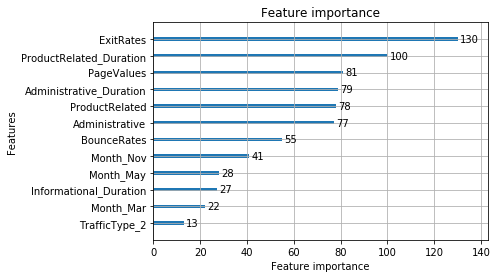

In [29]:
%matplotlib inline
lgb.plot_importance(clf_encoded,max_num_features=12)


### Conclusion
##### The top 12 features affecting the buying intentions were identified. These features can be further isolated depending upon the applications. For eg. Exit would be a good measure of how well personalized webpages are working for users. A simple A/B test can be carried out with and without personalization and exit rates as well as other features can be monitored. Change in these features would indicate a change in buying intent and tell us if the test was succesfull.